# Time diagrams

## Imports

In [1]:
{-# LANGUAGE NoMonomorphismRestriction #-}
{-# LANGUAGE FlexibleContexts          #-}
{-# LANGUAGE TypeFamilies              #-}

import System.Random
import Diagrams.Prelude
import Diagrams.Backend.Cairo

In [216]:
mkProcLabel :: String -> Diagram B
mkProcLabel lbl = 
  (text lbl # fontSizeL 5 # fc black <>
  rect 30 20 # lw 0 # lw 0) # translateX (-15)

mkProcLine :: String -> Diagram B
mkProcLine name = 
  mkProcLabel name |||
  arrowBetween' (with & arrowHead .~ tri & headLength .~ small) (p2 (0, 0)) (p2 (250,0)) # lwL 1 # lc black
    
mkEventLabel :: String
             -> Diagram B
mkEventLabel label = 
  circle 0.1 # lw 0 <>
  text label # fontSizeL 5 # translateY 5

mkEvent :: String -- ^ Name
        -> String -- ^ Label
        -> Double  -- ^ Start time
        -> Double  -- ^ Duration
        -> Diagram B
mkEvent name label start duration =
  (mkEventLabel label # showOrigin === (s <> t <> box)) # translate offset
  where
    offset = (start + duration/2) ^& 3.4
    box = rect duration 3 # lw 2
    s = mempty # named (name .> "start") # translateX (-duration/2)
    t = mempty # named (name .> "stop") # translateX (duration/2)
    
mkArrow :: ArrowOpts Double -> Bool -> Point V2 Double -> Point V2 Double ->  Diagram B
mkArrow opts dashed = arrowBetween' opts # lwL 1 # (if dashed then dashingN [0.01,0.01] 0 else id)
                              
mkPointLabel :: String -> Diagram B
mkPointLabel lbl = 
  text lbl # fontSizeL 5 # fc black <>
  square 20 # lw 0
  
mkPoint :: Double -- ^ X location
        -> String -- ^ Name
        -> String -- ^ Label
        -> (String -> Diagram B)
        -> Diagram B
mkPoint s nm lbl make =
  (make lbl # named nm) # translateX s
  
mkCircle :: String -> Diagram B
mkCircle lbl = (circle 3 # fc black # lw 0) === mkPointLabel lbl

noCircle :: String -> Diagram B
noCircle lbl = mkPointLabel lbl # translateY (-10)

mkLinearization :: String -> Diagram B
mkLinearization _ = 
  --rect 3 3 # fc red # lw 0 # translateY 1.5
  rect 3 13 # fc red # lw 0 # translateY 2.5

attach :: ArrowOpts Double -> Bool -> (Name, Name) -> Diagram B -> Diagram B
attach opts dashed (n1, n2) = 
  withName n1 $ \b1 ->
  withName n2 $ \b2 ->
       atop (mkArrow opts dashed (location b1) (location b2))
       
attachAll :: ArrowOpts Double -> Bool -> [(Name, Name)] -> Diagram B -> Diagram B
attachAll opts dashed = appEndo . foldMap (Endo . attach opts dashed)

mkWorldLine :: String  -- ^ Label
            -> Double  -- ^ Y axis
            -> [(String, String, Double, Double)] -- ^ Events
            -> [(Double, String, String, String -> Diagram B)] -- ^ Points with rendering function
            -> Diagram B
mkWorldLine name y es pts = 
  (mkProcLine name <> 
   mconcat events <> 
   mconcat points) # translateY y 
                   # (.>>) name
  where
    events = (\(nm,lbl,s,dur) -> mkEvent nm lbl s dur) <$> es
    points = (\(s, nm, lbl, make) -> mkPoint s nm lbl make) <$> pts

mkWorlds :: [(String, Double, [(String, String, Double, Double)], [(Double, String, String, String -> Diagram B)])]
         -> [(Name, Name)]
         -> ArrowOpts Double
         -> Bool
         -> Diagram B
mkWorlds worlds points opts dashed = 
    attachAll opts dashed points ws
  where
  ws = foldMap (\(name, y, events, pts) -> mkWorldLine name y events pts) worlds


### Request model

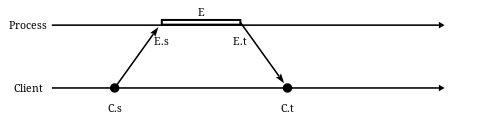

In [217]:
opts = def & arrowHead  .~ dart 
       & arrowTail .~ noTail
       & headLength .~ normal
       & tailLength .~ normal
       & headGap    .~ small
                
request = pad 1.1 $
     mkWorlds [ ("Process", 50, [("P1", "E", 70, 50)], [(70, "", "E.s", noCircle), (120, "", "E.t", noCircle)])
              , ("Client", 10, [], [(40, "S", "C.s", mkCircle), (150, "T", "C.t", mkCircle)])
              ]
              [ (toName "S", "P1" .> "start")
              , ("P1" .> "stop", toName "T")
              ]
              opts False
    
diagram request

### External order

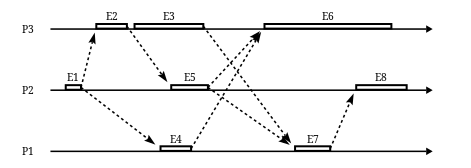

In [218]:
worldlines1 = pad 1.1 $
     mkWorlds [ ("P3", 80, [("P31", "E2", 30, 20), ("P32", "E3", 55, 45), ("P33", "E6", 140, 83)], [])
              , ("P2", 40, [("P21", "E1", 10, 10), ("P22", "E5", 79, 24), ("P23", "E8", 200, 33)], [])
              , ("P1", 0,  [("P11", "E4", 72, 20), ("P12", "E7", 160, 23)], [])
              ]
              [ ("P31" .> "stop", "P22" .> "start")
              , ("P32" .> "stop", "P12" .> "start")
              --, ("P32" .> "stop", "P23" .> "start")
              , ("P21" .> "stop", "P11" .> "start")
              , ("P22" .> "stop", "P33" .> "start")
              , ("P22" .> "stop", "P12" .> "start")
              , ("P21" .> "stop", "P31" .> "start")
              , ("P12" .> "stop", "P23" .> "start")
              , ("P11" .> "stop", "P33" .> "start")
              --, ("P32" .> "stop", "P33" .> "start")
              --, ("P22" .> "stop", "P23" .> "start")
              --, ("P21" .> "stop", "P22" .> "start")
              --, ("P11" .> "stop", "P12" .> "start")
              ]
              (with & arrowHead .~ dart 
                    & arrowTail .~ noTail
                    & headGap   .~ small) True
    
diagram worldlines1

Any of the following are okay orderings

$$ E1 \to E2 \to E3 \to E4 \to E5 \to E6 \to E7 \to E8 $$

$$ E1 \to E4 \to E2 \to E5 \to E3 \to E7 \to E8 \to E6 $$

$$ E1 \to E2 \to E5 \to E4 \to E3 \to E7 \to E6 \to E8 $$

The following are not permissible prefixes of a linearized history.


$$ E1 \to E3 \to E2 \to \ldots $$

Violates program order

$$ E1 \to E5 \to E2 \to \ldots $$

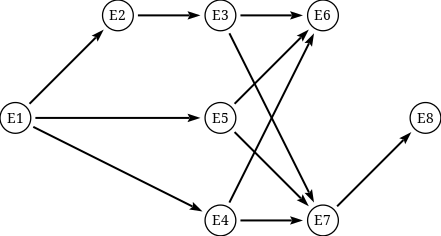

In [219]:
mkArrow :: ArrowOpts Double -> Bool -> Point V2 Double -> Point V2 Double ->  Diagram B
mkArrow opts dashed = arrowBetween' opts # lw 2
 
attach :: ArrowOpts Double -> Bool -> (Name, Name) -> Diagram B -> Diagram B
attach opts dashed (n1, n2) = 
  withName n1 $ \b1 ->
  withName n2 $ \b2 ->
       atop (mkArrow opts dashed (location b1) (location b2))
       
attachAll :: ArrowOpts Double -> Bool -> [(Name, Name)] -> Diagram B -> Diagram B
attachAll opts dashed = appEndo . foldMap (Endo . attach opts dashed)

opts = def & arrowHead  .~ dart 
       & arrowTail .~ noTail
       & headLength .~ normal
       & tailLength .~ normal
       & tailGap    .~ 20
       & headGap    .~ 20
       
mkNode :: String -> Double -> Double -> Diagram B
mkNode name x y = (circle 1.5 <> text name) # named name # translate (r2 (x, y))

diagram $ (mkNode "E1" 0 0 <> mkNode "E2" 10 10 <> mkNode "E3" 20 10 <> mkNode "E5" 20 0 <> mkNode "E4" 20 (-10) <> mkNode "E6" 30 10 <> mkNode "E7" 30 (-10) <> mkNode "E8" 40 (0)) 
  # attachAll opts True [(toName "E1", toName "E2"), (toName "E2", toName "E3"), (toName "E1", toName "E5"), (toName "E1", toName "E4"), (toName "E3", toName "E6"), (toName "E5", toName "E6")
  , (toName "E4", toName "E6"), (toName "E3", toName "E7"), (toName "E5", toName "E7"), (toName "E4", toName "E7"), (toName "E7", toName "E8")
  ]

## Linear consistency

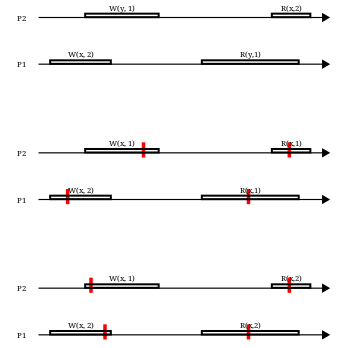

In [220]:
ex0 = pad 1.1 $
     mkWorlds [ ("P2", 40, [("P21", "W(y, 1)", 40, 63), ("P23", "R(x,2)", 200, 33)], [])
              , ("P1", 0,  [("P11", "W(x, 2)", 10, 52), ("P12", "R(y,1)", 140, 83)], [])
              ]
              [
              ] opts False
ex2 = pad 1.1 $
     mkWorlds [ ("P2", 40, [("P21", "W(x, 1)", 40, 63), ("P23", "R(x,2)", 200, 33)], [(45, "", "", mkLinearization), (215, "", "", mkLinearization)])
              , ("P1", 0,  [("P11", "W(x, 2)", 10, 52), ("P12", "R(x,2)", 140, 83)], [(57, "", "", mkLinearization), (180, "", "", mkLinearization)])
              ]
              [
              ]
              opts False
ex1 = pad 1.1 $
     mkWorlds [ ("P2", 40, [("P21", "W(x, 1)", 40, 63), ("P23", "R(x,1)", 200, 33)], [(90, "", "", mkLinearization), (215, "", "", mkLinearization)])
              , ("P1", 0,  [("P11", "W(x, 2)", 10, 52), ("P12", "R(x,1)", 140, 83)], [(25, "", "", mkLinearization), (180, "", "", mkLinearization)])
              ]
              [
              ]
              opts False
    
diagram (vsep 50 [ex0, ex1, ex2])

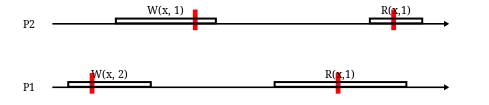

In [221]:
diagram ex1

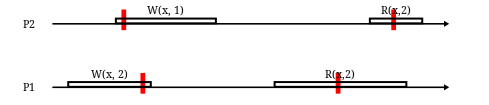

In [222]:
diagram ex2

On the other hand, the following history is not linearizable, as the read requests evidently disagree about whether the $W(x,1)$ or $W(x,2)$ event occurred first.

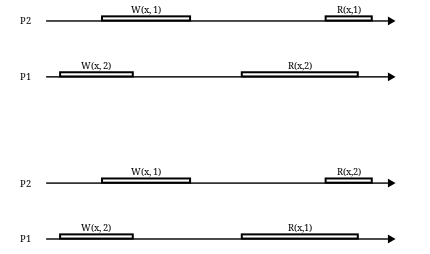

In [223]:
ex1 = pad 1.1 $
     mkWorlds [ ("P2", 40, [("P21", "W(x, 1)", 40, 63), ("P23", "R(x,1)", 200, 33)], [])
              , ("P1", 0,  [("P11", "W(x, 2)", 10, 52), ("P12", "R(x,2)", 140, 83)], [])
              ]
              [
              ]
              opts False
ex2 = pad 1.1 $
     mkWorlds [ ("P2", 40, [("P21", "W(x, 1)", 40, 63), ("P23", "R(x,2)", 200, 33)], [])
              , ("P1", 0,  [("P11", "W(x, 2)", 10, 52), ("P12", "R(x,1)", 140, 83)], [])
              ]
              [
              ]
              opts False
diagram $ vsep 50 [ex1, ex2]

## CAP Theorem

## Sequential Consistency

### Sequential but not linearizable

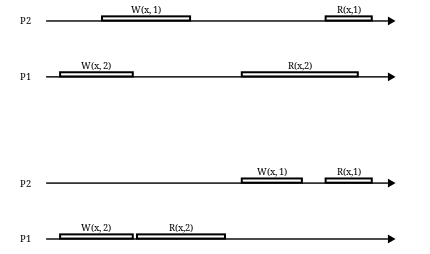

In [224]:
ex1 = pad 1.1 $
     mkWorlds [ ("P2", 40, [("P21", "W(x, 1)", 40, 63), ("P23", "R(x,1)", 200, 33)], [])
              , ("P1", 0,  [("P11", "W(x, 2)", 10, 52), ("P12", "R(x,2)", 140, 83)], [])
              ]
              [
              ]
              opts False
              
ex2 = pad 1.1 $
     mkWorlds [ ("P2", 40, [("P21", "W(x, 1)", 140, 43), ("P23", "R(x,1)", 200, 33)], [])
              , ("P1", 0,  [("P11", "W(x, 2)", 10, 52), ("P12", "R(x,2)", 65, 63)], [])
              ]
              [
              ]
              opts False

diagram $ vsep 50 [ex1, ex2]

### Non-sequentially consistent

### Sequential consistency is not composable

Here we see a history that is not sequentially consistent.

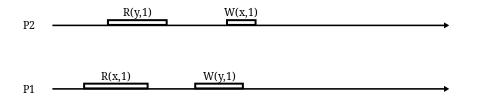

In [225]:
worldlines1 = pad 1.1 $
     mkWorlds [ ("P2", 50, [("P21", "R(y,1)", 35, 37), ("P22", "W(x,1)", 110, 18)], [])
              , ("P1", 10, [("P11", "R(x,1)", 20, 40), ("P12", "W(y,1)", 90, 30)], [])
              ]
              [ (toName "S", "P1" .> "start")
              , ("P1" .> "stop", toName "T")
              ]
              (with & arrowHead  .~ dart 
                & arrowTail .~ noTail
                & headLength .~ normal
                & tailLength .~ normal
                & headGap    .~ small) False
    
diagram worldlines1

On the other hand, $H|x$ and $H|y$ are both sequentially consistent. Therefore, to enforce sequential consistency, it does not suffice to enforce sequential consistency for each data item independently. One often says sequential consistency is not *composible*.

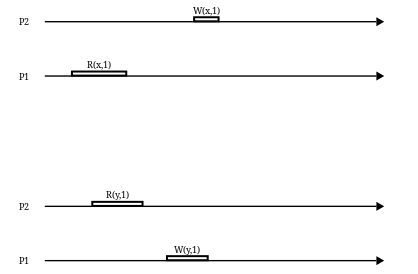

In [226]:
hx = pad 1.1 $
     mkWorlds [ ("P2", 50, [("P22", "W(x,1)", 110, 18)], [])
              , ("P1", 10, [("P11", "R(x,1)", 20, 40)], [])
              ]
              [ (toName "S", "P1" .> "start")
              , ("P1" .> "stop", toName "T")
              ] def False
hy = pad 1.1 $
     mkWorlds [ ("P2", 50, [("P21", "R(y,1)", 35, 37)], [])
              , ("P1", 10, [("P12", "W(y,1)", 90, 30)], [])
              ]
              [ (toName "S", "P1" .> "start")
              , ("P1" .> "stop", toName "T")
              ] def False
diagram (vsep 70 [hx, hy])

## Causal consistency

### Causally consistency but not sequentially consistent

### Causally inconsistent

## Topological models of network connectivity

In [227]:
n = 8

-- A routine for generating a random set of vectors
randomVectors = do
  g1 <- newStdGen
  g2 <- newStdGen
  let as = take n (randomRs (-1/15,1/15) g1) :: [Double]
  let rs = take n (randomRs (5, 22) g2)  :: [Double]
  print $ zipWith3 (\i a r -> r *^ angleV (1/8 * i + a @@ turn)) [0,1..] as rs
  
randomVectors

[V2 10.793092181172769 (-4.743329085124995),V2 6.594988220119443 6.790642640203065,V2 (-3.7406113779605006) 15.080361712393177,V2 (-14.424731656039443) 7.035234128062146,V2 (-14.116541547159423) (-0.8045675878207379),V2 (-6.857832449938337) (-12.640051850280813),V2 1.1283306462880112 (-6.667845317227053),V2 10.991536369165964 (-15.272505395147654)]

In [228]:
locs = [V2 21.4063406410043 (-1.1272911227127032),V2 24.37969880304756 10.057406303193646,V2 (-0.4726752351978615) 11.573848088897233,V2 (-10.59482468753915) 22.237593392371743,V2 (-9.556087413178094) 1.8164512857365724,V2 (-25.044888924086163) (-9.943164197495586),V2 (-8.03073387780946) (-24.58180088811591),V2 11.235468276950694 (-14.494605634108355)]

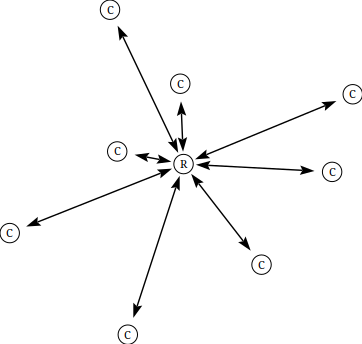

In [ ]:
mkArrow = arrowBetween' (with & arrowHead  .~ dart  & arrowTail .~ dart'
                                  & headLength .~ normal & tailLength .~ normal
                                  & tailGap    .~ large
                                  & headGap    .~ normal)
node :: String -> V2 Double -> Diagram B
node lbl vec = translate vec $
  text lbl # fontSizeL 1.2 # fc black <>
  circle 1.4 # fc white # lw 1 # lc black
  
nodes = map (\l -> node "C" l # named "p" <> mkArrow (origin .+^ l) (0 ^& 0)) locs

diagram $ node "R" (0 ^& 0) <> mconcat nodes